<a href="https://colab.research.google.com/github/peisuke/generative_ai_notebooks/blob/main/MultiModal/01_JapaneseInstructBLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://note.com/npaka/n/n371e25987267

In [2]:
# パッケージのインストール
!pip install transformers accelerate bitsandbytes
!pip install sentencepiece einops

In [3]:
from transformers import LlamaTokenizer, AutoModelForVision2Seq, BlipImageProcessor

# モデルとプロセッサーとトークナイザーの準備
model = AutoModelForVision2Seq.from_pretrained(
    "stabilityai/japanese-instructblip-alpha",
    trust_remote_code=True
).to("cuda")
processor = BlipImageProcessor.from_pretrained(
    "stabilityai/japanese-instructblip-alpha"
)
tokenizer = LlamaTokenizer.from_pretrained(
    "novelai/nerdstash-tokenizer-v1",
    additional_special_tokens=['▁▁']
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
from PIL import Image
import requests

# 画像の準備
image = Image.open("/content/PXL_20230212_045740346.jpg").convert("RGB")

In [5]:
# プロンプトの準備
prompt = """### 指示:
与えられた画像について、詳細に述べてください。

### 応答:"""

In [6]:
# 推論の実行
inputs = processor(images=image, return_tensors="pt")
text_encoding = tokenizer(prompt, add_special_tokens=False, return_tensors="pt")

text_encoding["qformer_input_ids"] = text_encoding["input_ids"].clone()
text_encoding["qformer_attention_mask"] = text_encoding["attention_mask"].clone()
inputs.update(text_encoding)

In [7]:
outputs = model.generate(
    **inputs.to("cuda", dtype=model.dtype),
    num_beams=5,
    max_new_tokens=32,
    min_length=1,
)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


2杯のコーヒーと1杯のコーヒー


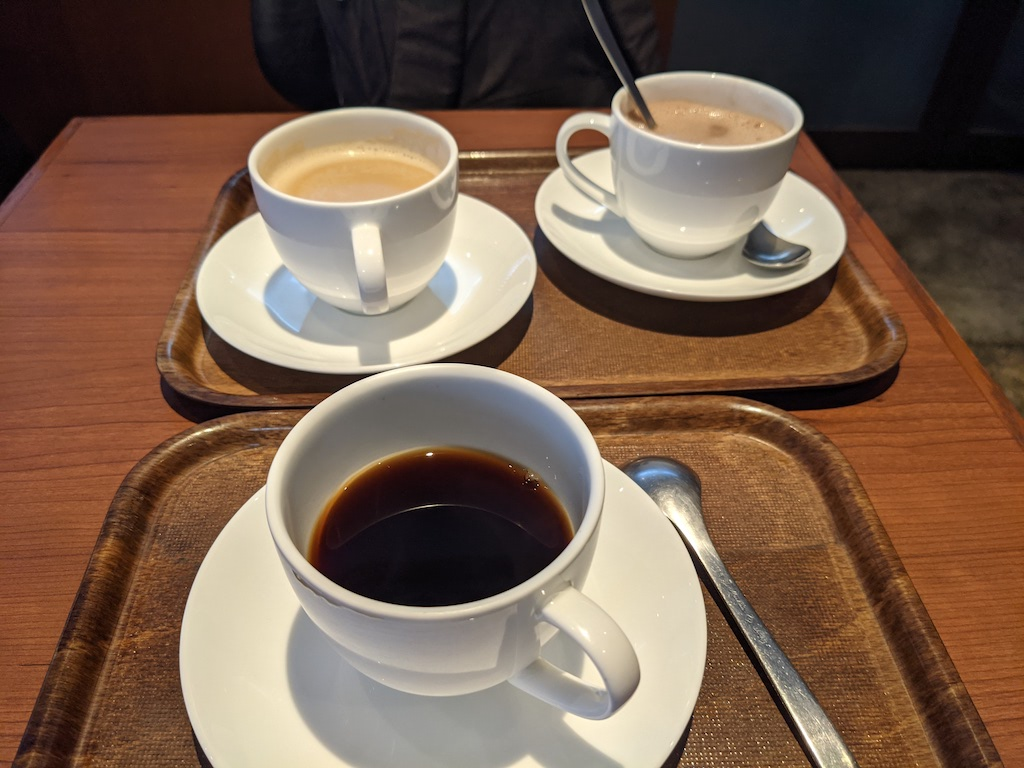

In [8]:
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)
image